In [2]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import get_environment
from lib.environments.kolmogorov import KolmogorovEnvironment, KolmogorovEnvironment3
from lib.policy import get_rl_algo
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default="CartPole-v1")
    parser.add_argument("--model", type=str, default="ppo")
    parser.add_argument("--reward_threshold", type=int, default=500)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--buffer_size", type=int, default=20000)
    parser.add_argument("--max_epoch", type=int, default=10)
    parser.add_argument("--step_per_epoch", type=int, default=100)
    parser.add_argument("--train_num", type=int, default=1)
    parser.add_argument("--test_num", type=int, default=1)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--gamma", type=float, default=0.90)
    parser.add_argument("--lr", help='learning rate', type=float, default=1e-4)
    parser.add_argument("--repeat_per_collect", type=int, default=1)
    parser.add_argument("--episode_per_test", type=int, default=1)
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--step_per_collect", type=int, default=200) 
    parser.add_argument("--architecture", type=int, default=[64, 64])
    parser.add_argument("--backbone_out_dim", type=int, default=64)

    return parser.parse_known_args()[0]


def create_env(kwargs1, kwargs2, min_a=-1., max_a=1., step_factor=10, max_t=100):
    """
    creates the environemnt and applyes wrappers to action and
    observations space and sets time limit.
    """
    env = KolmogorovEnvironment3(kwargs1, kwargs2, step_factor=step_factor, max_episode_steps=max_t)
    #env = TimeLimit(env, max_episode_steps=max_t)
    return env


In [4]:
#######################################################################################################
####### setup stuff *##################################################################################
#######################################################################################################
args = get_args()
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
#restrict_to_num_threads(1)

In [5]:
#######################################################################################################
####### environments ##################################################################################
#######################################################################################################
u0_path = "/home/pfischer/XLB/vel_init/velocity_burn_in_1806594.npy" #4096x4096 simulation
rho0_path = "/home/pfischer/XLB/vel_init/density_burn_in_1806594.npy" #4096x4096 simulation
kwargs1, T1,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #cgs 
kwargs2, T2,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #fgs
step_factor=10
#check if cgs time is a factor of fgs time
assert (T2%T1 == 0)
env = create_env(kwargs1, kwargs2, step_factor=step_factor,  max_t=100)
check_env(env)

m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0
m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0


/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [ ]:
# testing if local omega works

step=0
1.0


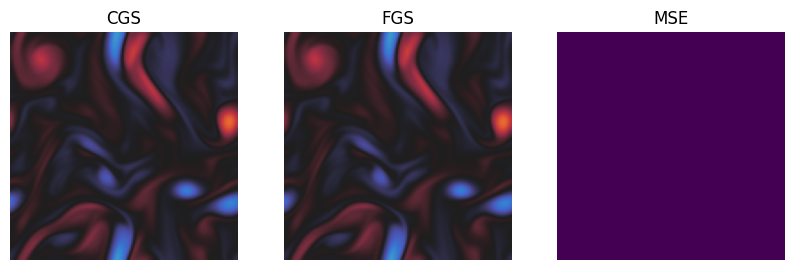

step=25
0.9627403050386578


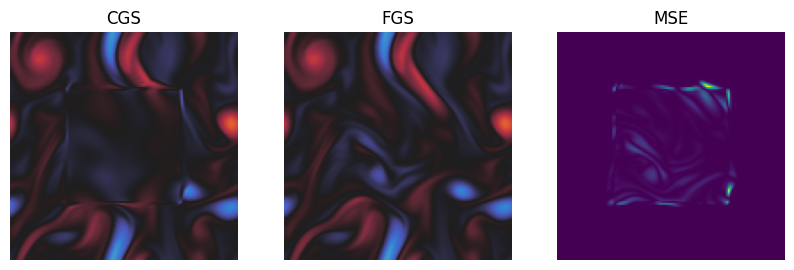

step=50
0.9429943140765448


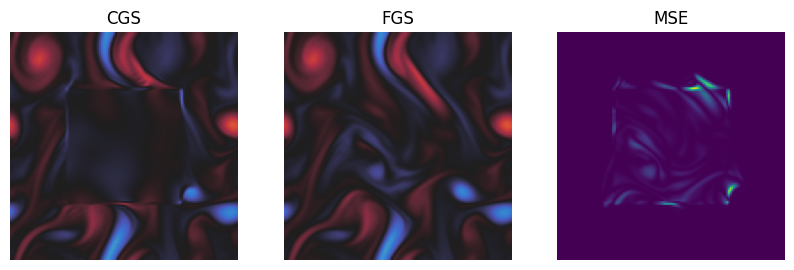

step=75
0.9315146690970098


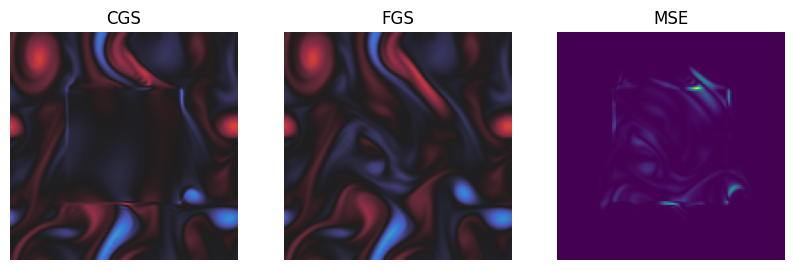

: 

In [13]:
obs, inf = env.reset()
alphas = np.ones(env.omg.shape)
alphas[32:96, 32:96, 0] = 0.8
for i in range(100):
    if i%25==0:
        print(f"step={i}")
        env.render()
    out = env.step(alphas)
env.close()

# Levels of abstaction of Reinforce

In [4]:
env = gym.make('Pendulum-v1')
test_env = gym.make('Pendulum-v1')

#Policy
net = Net(state_shape=env.observation_space.shape, hidden_sizes=[32, 16], device=device).to(device)
actor = ActorProb(preprocess_net=net, action_shape=env.action_space.shape, max_action=1, device=device).to(device)
optim = torch.optim.AdamW(actor.parameters(), lr=0.0001)
dist = torch.distributions.Normal
policy = PGPolicy(model=actor,optim=optim,dist_fn=dist,action_space=env.action_space,
    discount_factor=0.97,reward_normalization=False,deterministic_eval=True,
    observation_space=env.observation_space,action_scaling=True,action_bound_method = "tanh",
)

#Collectors
train_collector = Collector(policy=policy,env=env,buffer=ReplayBuffer(20000))
test_collector = Collector(policy=policy, env=test_env)

#Trainer
trainer = OnpolicyTrainer(policy=policy,train_collector=train_collector,test_collector=test_collector,
    max_epoch=2, step_per_epoch=100, repeat_per_collect=1, episode_per_test=1, batch_size=16,
    episode_per_collect=1, show_progress=True, stop_fn=lambda mean_reward: mean_reward >= -200,
)

/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/tianshou/data/collector.py:69: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


## Level 1

In [5]:
#trainer.run iterates automatically
result = trainer.run()

Epoch #1: 200it [00:00, 573.21it/s, env_step=200, len=200, loss=-251.742, n/ep=1, n/st=200, rew=-1411.40] 


Epoch #1: test_reward: -1324.683969 ± 0.000000, best_reward: -1097.753524 ± 0.000000 in #0


Epoch #2: 200it [00:00, 903.28it/s, env_step=400, len=200, loss=-274.883, n/ep=1, n/st=200, rew=-1487.24] 

Epoch #2: test_reward: -1205.690573 ± 0.000000, best_reward: -1097.753524 ± 0.000000 in #0


## Level 2

In [6]:
#call iterator explicitly
N = trainer.max_epoch
rew_stats = np.zeros((N,2))
trainer.reset()
i=0
for step_stats in trainer:
    rew_stats[i,0] = step_stats[1]['test_reward']
    rew_stats[i,1] = step_stats[1]['test_reward_std']
    i+=1

Epoch #1: 200it [00:00, 931.21it/s, env_step=200, len=200, loss=-286.000, n/ep=1, n/st=200, rew=-1574.60] 

Epoch #1: test_reward: -1109.499624 ± 0.000000, best_reward: -1109.499624 ± 0.000000 in #1



Epoch #2: 200it [00:00, 934.58it/s, env_step=400, len=200, loss=-283.614, n/ep=1, n/st=200, rew=-1328.06] 

Epoch #2: test_reward: -1096.787658 ± 0.000000, best_reward: -1096.787658 ± 0.000000 in #2


## Level 3

In [7]:
from tianshou.trainer.utils import gather_info, test_episode

In [10]:
def perform_epoch():
    """Perform one epoch (both train and eval)."""
    trainer.epoch += 1
    trainer.iter_num += 1
    if trainer.iter_num > 1:
        # iterator exhaustion check
        if trainer.epoch > trainer.max_epoch:
            print("stop iteration")
        # exit flag 1, when stop_fn succeeds in train_step or test_step
        if trainer.stop_fn_flag:
            print("stop iteration")
    # set policy in train mode
    trainer.policy.train()
    epoch_stat = dict()

    if trainer.show_progress:
        progress = tqdm
    else:
        progress = DummyTqdm
    # perform n step_per_epoch
    with progress(total=trainer.step_per_epoch, desc=f"Epoch #{trainer.epoch}") as t:
        while t.n < t.total and not trainer.stop_fn_flag:
            data = dict()
            result = dict()
            if trainer.train_collector is not None:
                data, result, trainer.stop_fn_flag = trainer.train_step()
                t.update(result["n/st"])
                if trainer.stop_fn_flag:
                    t.set_postfix(**data)
                    break
            else:
                assert trainer.buffer, "No train_collector or buffer specified"
                result["n/ep"] = len(trainer.buffer)
                result["n/st"] = int(trainer.gradient_step)
                t.update()
            trainer.policy_update_fn(data, result)
            t.set_postfix(**data)
        if t.n <= t.total and not trainer.stop_fn_flag:
            t.update()

    # for offline RL
    if trainer.train_collector is None:
        trainer.env_step = trainer.gradient_step * trainer.batch_size
    if not trainer.stop_fn_flag:
        trainer.logger.save_data(
            trainer.epoch, trainer.env_step, trainer.gradient_step, trainer.save_checkpoint_fn
        )
        # test
        if trainer.test_collector is not None:
            test_stat, trainer.stop_fn_flag = trainer.test_step()
            if not trainer.is_run:
                epoch_stat.update(test_stat)
    if not trainer.is_run:
        epoch_stat.update({k: v.get() for k, v in trainer.stat.items()})
        epoch_stat["gradient_step"] = trainer.gradient_step
        epoch_stat.update(
            {
                "env_step": trainer.env_step,
                "rew": trainer.last_rew,
                "len": int(trainer.last_len),
                "n/ep": int(result["n/ep"]),
                "n/st": int(result["n/st"]),
            }
        )
        info = gather_info(
            trainer.start_time, trainer.train_collector, trainer.test_collector,
            trainer.best_reward, trainer.best_reward_std
        )
        print("return")
    else:
        print("no return")

In [11]:
trainer.reset()
for epoch in range(trainer.max_epoch):
    perform_epoch()

Epoch #1: 200it [00:00, 648.23it/s, env_step=200, len=200, loss=-266.237, n/ep=1, n/st=200, rew=-938.28]


Epoch #1: test_reward: -1109.086160 ± 0.000000, best_reward: -1109.086160 ± 0.000000 in #1
return


Epoch #2: 200it [00:00, 642.51it/s, env_step=400, len=200, loss=-279.039, n/ep=1, n/st=200, rew=-1730.31]


Epoch #2: test_reward: -1233.221382 ± 0.000000, best_reward: -1109.086160 ± 0.000000 in #1
return


## Level 4

In [20]:
# get rid of the trainer object (almost) and swich to loop instead of iterator
epochs = 2
step_per_epoch = 100
global_iter_num = 1 #counts what? 
stop_fn_flag = False #should be set to true if stop_fn otputs true
show_progress = True #flag indicating the visualization of a progress bar
trainer.reset()

for epoch in range(1,epochs+1):
    """Perform one epoch (both train and eval)."""
    global_iter_num += 1
    trainer.epoch+=1
    if global_iter_num > 1:
        # exit flag 1, when stop_fn succeeds in train_step or test_step
        if stop_fn_flag:
            print("stop iteration due to stop_fn_flag")
            break
    
    policy.train() #set policy in train mode
    epoch_stat = dict() #dictionary to save epoch statistics


    # perform n step_per_epoch
    progress = tqdm if show_progress else DummyTqdm
    with progress(total=step_per_epoch, desc=f"Epoch #{epoch}") as t:
        while t.n < t.total and not stop_fn_flag:
            data = dict()
            result = dict()
            if trainer.train_collector is not None:
                data, result, stop_fn_flag = trainer.train_step()
                t.update(result["n/st"]) #updates the counter t with the total number of steps taken in the last train_step update!
                if trainer.stop_fn_flag:
                    t.set_postfix(**data) #sets print output of progress bar
                    break #breaks while loop in case stop_fn is true
            else:
                print("WARNING: o train_collector was found")
                assert trainer.buffer, "No train_collector or buffer specified"
                result["n/ep"] = len(trainer.buffer)
                result["n/st"] = int(trainer.gradient_step)
                t.update()

            #updates the policy with the collected data and results 
            trainer.policy_update_fn(data, result)
            t.set_postfix(**data)


    # for offline RL
    if trainer.train_collector is None:
        trainer.env_step = trainer.gradient_step * trainer.batch_size
    
    # loggs training data if stop_fn_flag is not true jet, hence logs testing stats after each epoch
    if not trainer.stop_fn_flag:
        trainer.logger.save_data(epoch, trainer.env_step, trainer.gradient_step, trainer.save_checkpoint_fn)
        # performs a test
        if trainer.test_collector is not None:
            test_stat, trainer.stop_fn_flag = trainer.test_step()
            if not trainer.is_run: #if trainer isn't running 
                epoch_stat.update(test_stat)

    # if trainer is not running -> meaning logs training stats after each epoch if trainer has finished 
    if not trainer.is_run:
        epoch_stat.update({k: v.get() for k, v in trainer.stat.items()})
        epoch_stat["gradient_step"] = trainer.gradient_step
        epoch_stat.update(
            {
                "env_step": trainer.env_step,
                "rew": trainer.last_rew,
                "len": int(trainer.last_len),
                "n/ep": int(result["n/ep"]),
                "n/st": int(result["n/st"]),
            }
        )
        info = gather_info(
            trainer.start_time, trainer.train_collector, trainer.test_collector,
            trainer.best_reward, trainer.best_reward_std
        )
        print("return")
        #TODO: do something with the info here

    else:
        print("no return cause trainer is still running")

Epoch #1: 200it [00:00, 642.36it/s, env_step=200, len=200, loss=-228.190, n/ep=1, n/st=200, rew=-1004.87]


Epoch #1: test_reward: -1334.170341 ± 0.000000, best_reward: -1334.170341 ± 0.000000 in #1
return


Epoch #2: 200it [00:00, 637.01it/s, env_step=400, len=200, loss=-231.842, n/ep=1, n/st=200, rew=-1574.88]


Epoch #2: test_reward: -1309.158402 ± 0.000000, best_reward: -1309.158402 ± 0.000000 in #2
return


In [ ]:
# what exactly is trainer.is_run doing?
# -> indicator if trainer is running a training at the moment
# -> can only be switched to true in trainer.run()

## Level 5

In [22]:
# look what happens in trainer.train_step
# train step doesn't actually perform a policy update. Instead it calls the collector to collect a certain number of interactions
# with the environment
def train_step():
        """Perform one training step."""
        assert trainer.episode_per_test is not None
        assert trainer.train_collector is not None
        stop_fn_flag = False

        #what does train_fn do?
        if trainer.train_fn:
            trainer.train_fn(trainer.epoch, trainer.env_step)

        #collect either step_per_collect or episode_per_collect results
        result = trainer.train_collector.collect(n_step=trainer.step_per_collect, n_episode=trainer.episode_per_collect)

        #transforms rewards
        if result["n/ep"] > 0 and trainer.reward_metric:
            rew = trainer.reward_metric(result["rews"]) #seems to apply the reward_metric ontop of the collected rewards
            result.update(rews=rew, rew=rew.mean(), rew_std=rew.std())

        trainer.env_step += int(result["n/st"]) #n/st measures the total number of steps taken in the environment
        trainer.logger.log_train_data(result, trainer.env_step) #logs training data
        trainer.last_rew = result["rew"] if result["n/ep"] > 0 else trainer.last_rew #updates last reward if a whole episode was played
        trainer.last_len = result["len"] if result["n/ep"] > 0 else trainer.last_len #updates last length if a whole episode was played

        #updated printed statistics of the call to train_step
        data = {
            "env_step": str(trainer.env_step),
            "rew": f"{trainer.last_rew:.2f}",
            "len": str(int(trainer.last_len)),
            "n/ep": str(int(result["n/ep"])),
            "n/st": str(int(result["n/st"])),
        }

        if result["n/ep"] > 0:
            #if stop_fn returns true on training data we perform a test and check if stop_fn also
            #returns true on testing data. If so, we stop everything by setting stop_fn_flag = True
            if trainer.test_in_train and trainer.stop_fn and trainer.stop_fn(result["rew"]):
                assert trainer.test_collector is not None
                test_result = test_episode(
                    trainer.policy, trainer.test_collector, trainer.test_fn, trainer.epoch,
                    trainer.episode_per_test, trainer.logger, trainer.env_step
                )

                if trainer.stop_fn(test_result["rew"]):
                    stop_fn_flag = True
                    trainer.best_reward = test_result["rew"]
                    trainer.best_reward_std = test_result["rew_std"]
                else:
                    trainer.policy.train()

        # returns results of training, not of testing!
        return data, result, stop_fn_flag

In [24]:
# get rid of the trainer object (almost) and swich to loop instead of iterator

epochs = 2
step_per_epoch = 100
global_iter_num = 1 #counts what? 
stop_fn_flag = False #should be set to true if stop_fn otputs true
show_progress = True #flag indicating the visualization of a progress bar
trainer.reset()

for epoch in range(1,epochs+1):
    """Perform one epoch (both train and eval)."""
    global_iter_num += 1
    trainer.epoch+=1
    if global_iter_num > 1:
        # exit flag 1, when stop_fn succeeds in train_step or test_step
        if stop_fn_flag:
            print("stop iteration due to stop_fn_flag")
            break
    
    policy.train() #set policy in train mode
    epoch_stat = dict() #dictionary to save epoch statistics


    # perform n step_per_epoch
    progress = tqdm if show_progress else DummyTqdm
    with progress(total=step_per_epoch, desc=f"Epoch #{epoch}") as t:
        while t.n < t.total and not stop_fn_flag:
            data = dict()
            result = dict()
            #********************************************************************************************************************
            #PERFORM A COLLECT STEP *********************************************************************************************
            #********************************************************************************************************************
            if trainer.train_collector is not None:
                data, result, stop_fn_flag = train_step()
                t.update(result["n/st"]) #updates the counter t with the total number of steps taken in the last train_step update!
                if trainer.stop_fn_flag:
                    t.set_postfix(**data) #sets print output of progress bar
                    break #breaks while loop in case stop_fn is true
            #********************************************************************************************************************
            #********************************************************************************************************************
            #********************************************************************************************************************
            else:
                print("WARNING: o train_collector was found")
                assert trainer.buffer, "No train_collector or buffer specified"
                result["n/ep"] = len(trainer.buffer)
                result["n/st"] = int(trainer.gradient_step)
                t.update()

            #********************************************************************************************************************
            #PERFORM A POLICY UPDATE ********************************************************************************************
            #********************************************************************************************************************
            #updates the policy with the collected data and results 
            trainer.policy_update_fn(data, result)
            t.set_postfix(**data)
            #********************************************************************************************************************
            #********************************************************************************************************************
            #********************************************************************************************************************


    # for offline RL
    if trainer.train_collector is None:
        trainer.env_step = trainer.gradient_step * trainer.batch_size
    
    # loggs training data if stop_fn_flag is not true jet, hence logs testing stats after each epoch
    if not trainer.stop_fn_flag:
        trainer.logger.save_data(trainer.epoch, trainer.env_step, trainer.gradient_step, trainer.save_checkpoint_fn)
        #********************************************************************************************************************
        # PERFORM A TESTING STEP ********************************************************************************************
        #********************************************************************************************************************
        if trainer.test_collector is not None:
            test_stat, trainer.stop_fn_flag = trainer.test_step()
            if not trainer.is_run: #if trainer isn't running 
                epoch_stat.update(test_stat)
        #********************************************************************************************************************
        #********************************************************************************************************************
        #********************************************************************************************************************
        

    # if trainer is not running -> meaning logs training stats after each epoch if trainer has finished 
    if not trainer.is_run:
        epoch_stat.update({k: v.get() for k, v in trainer.stat.items()})
        epoch_stat["gradient_step"] = trainer.gradient_step
        epoch_stat.update(
            {
                "env_step": trainer.env_step,
                "rew": trainer.last_rew,
                "len": int(trainer.last_len),
                "n/ep": int(result["n/ep"]),
                "n/st": int(result["n/st"]),
            }
        )
        info = gather_info(
            trainer.start_time, trainer.train_collector, trainer.test_collector,
            trainer.best_reward, trainer.best_reward_std
        )
        print("return")
        #TODO: do something with the info here -> or just return it

    else:
        print("no return cause trainer is still running")

Epoch #1: 200it [00:00, 617.11it/s, env_step=200, len=200, loss=-239.459, n/ep=1, n/st=200, rew=-1718.49]


Epoch #1: test_reward: -1305.770693 ± 0.000000, best_reward: -1230.664167 ± 0.000000 in #0
return


Epoch #2: 200it [00:00, 900.35it/s, env_step=400, len=200, loss=-238.522, n/ep=1, n/st=200, rew=-1171.89] 

Epoch #2: test_reward: -1268.367809 ± 0.000000, best_reward: -1230.664167 ± 0.000000 in #0
return


## Level 5

In [ ]:
# understand policy_update_fn
def policy_update_fn(self, data, result):
        """Perform one on-policy update."""
        assert self.train_collector is not None
        
        losses = self.policy.update(
            0,
            self.train_collector.buffer,
            batch_size=self.batch_size,
            repeat=self.repeat_per_collect,
        )
        self.train_collector.reset_buffer(keep_statistics=True)
        step = max([1] + [len(v) for v in losses.values() if isinstance(v, list)])
        self.gradient_step += step
        self.log_update_data(data, losses)

In [ ]:
# -> basically calls policy.update with the buffer
def update(self, sample_size, buffer, **kwargs):
        """Update the policy network and replay buffer.

        It includes 3 function steps: process_fn, learn, and post_process_fn. In
        addition, this function will change the value of ``self.updating``: it will be
        False before this function and will be True when executing :meth:`update`.
        Please refer to :ref:`policy_state` for more detailed explanation.

        :param int sample_size: 0 means it will extract all the data from the buffer,
            otherwise it will sample a batch with given sample_size.
        :param ReplayBuffer buffer: the corresponding replay buffer.

        :return: A dict, including the data needed to be logged (e.g., loss) from
            ``policy.learn()``.
        """
        if buffer is None:
            return {}
        batch, indices = buffer.sample(sample_size)
        self.updating = True
        batch = self.process_fn(batch, buffer, indices)
        result = self.learn(batch, **kwargs)
        self.post_process_fn(batch, buffer, indices)
        if self.lr_scheduler is not None:
            self.lr_scheduler.step()
        self.updating = False
        return result

In [ ]:
#-> process_fn
def process_fn(self, batch, buffer, indices)
        """Compute the discounted returns for each transition.
        .. math::
            G_t = \sum_{i=t}^T \gamma^{i-t}r_i
        """
        v_s_ = np.full(indices.shape, self.ret_rms.mean)
        unnormalized_returns, _ = self.compute_episodic_return(batch, buffer, indices, 
                                        v_s_=v_s_, gamma=self._gamma, gae_lambda=1.0)
        if self._rew_norm:
            batch.returns = (unnormalized_returns - self.ret_rms.mean)/np.sqrt(self.ret_rms.var + self._eps)
            self.ret_rms.update(unnormalized_returns)
        else:
            batch.returns = unnormalized_returns
        return batch

In [ ]:
# ->learn
def learn(self, batch, batch_size, repeat, **kwargs):
        losses = []
        for _ in range(repeat):
            for minibatch in batch.split(batch_size, merge_last=True):
                self.optim.zero_grad()
                result = self(minibatch) #forward pass of NN
                dist = result.dist
                act = to_torch_as(minibatch.act, result.act)
                ret = to_torch(minibatch.returns, torch.float, result.act.device)
                log_prob = dist.log_prob(act).reshape(len(ret), -1).transpose(0, 1)
                loss = -(log_prob * ret).mean()
                loss.backward()
                self.optim.step()
                losses.append(loss.item())

        return {"loss": losses}

## Level 6

In [ ]:
# understand collector=?! and buffer and batch data structure

## Level 100 -> PSEUDOCODE

In [ ]:
#pseudo code

for epoch in range(epochs):

    step=0
    while step < steps_per_epoch:
        
        ### COLLECTING ******************************************************
        #********************************************************************
        #collect steps_per_collect / episode per collect
        data, result, trainer.stop_fn_flag = trainer.train_step()
        #********************************************************************

        ### POLICY UPDATE ***************************************************
        #********************************************************************
        trainer.policy_update_fn(data, result)
        #->inside policy_pudate_fn:
            for i in range(repeat_per_collect):
                #split the episode into batches of size batch_size
                for batch in batches:
                    #forward pass -> loss computation -> backward pass
                    # -> optimizer step
        #discard experience!
        #********************************************************************

        ### TESTING *********************************************************
        #********************************************************************
        test_stat, trainer.stop_fn_flag = trainer.test_step()
        #********************************************************************

        #update steps taken
        step+=results["n/st"]